In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.plotting import figure
from bokeh.io import output_file, show, output_notebook
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter
import nltk
from nltk.corpus import stopwords
import spacy
from spacy.util import compounding
from spacy.util import minibatch
from spacy import displacy
import gc
import os

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
sns.set(rc={'figure.figsize':(20,10)})

In [3]:
csv_collection = []
for dirname, _, filenames in os.walk('../input/ukraine-russian-crisis-twitter-dataset-1-2-m-rows'):
    for filename in filenames:
        fullpath = os.path.join(dirname, filename)
        csv_collection.append(fullpath)

In [4]:
csv_collection

['../input/ukraine-russian-crisis-twitter-dataset-1-2-m-rows/UkraineCombinedTweetsDeduped_FEB27.csv.gzip',
 '../input/ukraine-russian-crisis-twitter-dataset-1-2-m-rows/UkraineCombinedTweetsDeduped_MAR07.csv.gzip',
 '../input/ukraine-russian-crisis-twitter-dataset-1-2-m-rows/UkraineCombinedTweetsDeduped_MAR08.csv.gzip',
 '../input/ukraine-russian-crisis-twitter-dataset-1-2-m-rows/UkraineCombinedTweetsDeduped_FEB28_part2.csv.gzip',
 '../input/ukraine-russian-crisis-twitter-dataset-1-2-m-rows/UkraineCombinedTweetsDeduped_MAR04.csv.gzip',
 '../input/ukraine-russian-crisis-twitter-dataset-1-2-m-rows/UkraineCombinedTweetsDeduped_MAR06.csv.gzip',
 '../input/ukraine-russian-crisis-twitter-dataset-1-2-m-rows/UkraineCombinedTweetsDeduped_FEB28_part1.csv.gzip',
 '../input/ukraine-russian-crisis-twitter-dataset-1-2-m-rows/UkraineCombinedTweetsDeduped_MAR03.csv.gzip',
 '../input/ukraine-russian-crisis-twitter-dataset-1-2-m-rows/UkraineCombinedTweetsDeduped_MAR02.csv.gzip',
 '../input/ukraine-russia

In [5]:
df = pd.read_csv(csv_collection.pop(), compression = 'gzip', index_col = 0)
for data in csv_collection:
    try:
        tmp = pd.read_csv(data, compression = 'gzip', index_col = 0)
    except:
        tmp = pd.read_csv(data, index_col = 0)
    df = pd.concat([df, tmp], axis=0)

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/conda/lib/python3.7/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [6]:
df.shape

(5867587, 17)

In [7]:
df.columns

Index(['userid', 'username', 'acctdesc', 'location', 'following', 'followers',
       'totaltweets', 'usercreatedts', 'tweetid', 'tweetcreatedts',
       'retweetcount', 'text', 'hashtags', 'language', 'coordinates',
       'favorite_count', 'extractedts'],
      dtype='object')

In [8]:
df.language.value_counts()

en     3837590
fr      310409
de      240212
es      234103
und     227704
        ...   
hy          42
km          33
dv          32
ug           9
lo           3
Name: language, Length: 65, dtype: int64

In [9]:
df.language.value_counts().index

Index(['en', 'fr', 'de', 'es', 'und', 'th', 'it', 'hi', 'tr', 'ja', 'pl', 'ru',
       'ar', 'uk', 'pt', 'ta', 'nl', 'in', 'fa', 'zh', 'fi', 'el', 'cs', 'ur',
       'ro', 'et', 'ca', 'da', 'gu', 'sv', 'ko', 'mr', 'kn', 'te', 'tl', 'bn',
       'iw', 'no', 'ml', 'lv', 'ht', 'pa', 'sl', 'or', 'cy', 'vi', 'lt', 'eu',
       'ka', 'ne', 'am', 'hu', 'sr', 'ps', 'bg', 'ckb', 'my', 'si', 'is', 'sd',
       'hy', 'km', 'dv', 'ug', 'lo'],
      dtype='object')

<AxesSubplot:ylabel='language'>

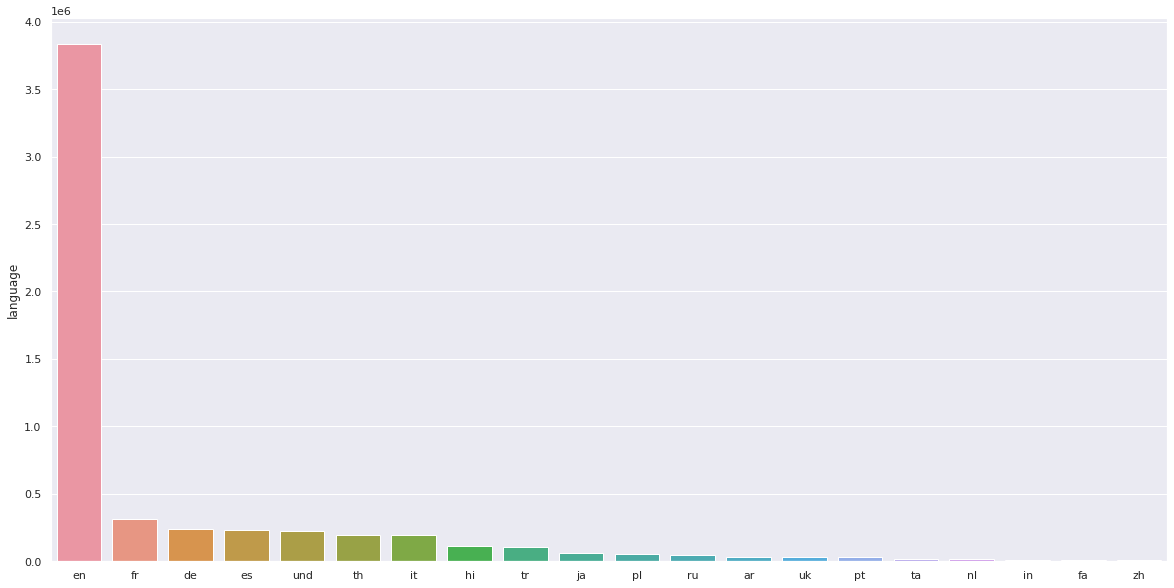

In [10]:
sns.barplot(x = df.language.value_counts()[:20].index, y = df.language.value_counts()[:20])

In [11]:
df.groupby('language').nunique()

,userid,username,acctdesc,location,following,followers,totaltweets,usercreatedts,tweetid,tweetcreatedts,retweetcount,text,hashtags,coordinates,favorite_count,extractedts
language,,,,,,,,,,,,,,,,
am,233,233,151,60,213,253,311,233,317,317,53,134,119,0,5,317
ar,14104,14160,10690,3666,4619,8751,19949,14104,34360,31965,661,20036,18142,0,30,34360
bg,195,195,142,97,189,162,217,195,226,226,31,164,149,0,6,226
bn,582,582,483,232,506,1210,1913,582,2117,2111,51,1814,1729,0,11,2117
ca,4448,4451,3547,1896,2403,2471,4826,4448,5320,5275,409,2616,2403,2,14,5320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
uk,17881,17902,12184,5016,3402,3747,18470,17878,30483,28277,1923,10875,7590,15,110,30483
und,147152,147311,117190,40942,11197,15039,72884,147093,224161,161461,8275,140665,98231,24,75,224161
ur,3989,3992,3085,1107,2244,2777,5336,3989,6260,6204,382,3320,2661,0,25,6260


In [12]:
df_en = df[df.language == 'en'].drop('language', axis=1)

In [13]:
#just continue with english for now
sorted_tweets = df_en[['username', 'text', 'retweetcount', 'tweetid', ]].sort_values(by = 'retweetcount', ascending = False)

In [14]:
most_retweeted = sorted_tweets.iloc[0]
print(most_retweeted.text)

.@ZelenskyyUa's tv address to the Russian (!) people might be the most moving speech that I've ever seen in my entire life. The whole world needs to see, understand and share this crucial Ukrainian message.
#StandWithUkraine #Ukraine #Україна #Russia #Россия https://t.co/WoMOgqXTWX


<blockquote class="twitter-tweet"><p lang="en" dir="ltr">.<a href="https://twitter.com/ZelenskyyUa?ref_src=twsrc%5Etfw">@ZelenskyyUa</a>&#39;s tv address to the Russian (!) people might be the most moving speech that I&#39;ve ever seen in my entire life. The whole world needs to see, understand and share this crucial Ukrainian message.<a href="https://twitter.com/hashtag/StandWithUkraine?src=hash&amp;ref_src=twsrc%5Etfw">#StandWithUkraine</a> <a href="https://twitter.com/hashtag/Ukraine?src=hash&amp;ref_src=twsrc%5Etfw">#Ukraine</a> <a href="https://twitter.com/hashtag/%D0%A3%D0%BA%D1%80%D0%B0%D1%97%D0%BD%D0%B0?src=hash&amp;ref_src=twsrc%5Etfw">#Україна</a> <a href="https://twitter.com/hashtag/Russia?src=hash&amp;ref_src=twsrc%5Etfw">#Russia</a> <a href="https://twitter.com/hashtag/%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D1%8F?src=hash&amp;ref_src=twsrc%5Etfw">#Россия</a> <a href="https://t.co/WoMOgqXTWX">pic.twitter.com/WoMOgqXTWX</a></p>&mdash; Patrick Moelleken 🇺🇦 (@PMoelleken) <a href="https://twitter.com/PMoelleken/status/1496941845812760577?ref_src=twsrc%5Etfw">February 24, 2022</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script> 

To find another Tweet use: twitter.com/anyuser/status/{tweetid}

In [15]:
#for example the above was found with
sorted_tweets.tweetid.iloc[0]

1501300567582420998

In [16]:
sorted_tweets.tail(10)

,username,text,retweetcount,tweetid
1525510,thetribunechd,#TribuneEdit: The #RussiaUkraineWar is making...,0,1498114697828368387
657179,iceolowo,We need a million likes for the greatest presi...,0,1497306845408595968
657180,Nirav777,A trending video (not verified) on @Reddit: a ...,0,1497306845454561281
3335297,burdulanuk19,"@Europarl_EN #Europe, #StopPutin NOW or you wi...",0,1500847079228334083
3335300,ELA8th,@ellisonbarber @MSNBC #NATO step up to help Uk...,0,1500847080184729601
3335304,Sonik0077,@ua_parliament @EmmanuelMacron @vonderleyen @e...,0,1500847080788668416
2316236,Nalyvai_V,"@MasudGh #NATO members, we plead to protect th...",0,1500200862530088966
3335307,thewavecapital,Strong #speech by #PresidentBiden. Widespread ...,0,1500847080864206851
2316232,Romin35537896,@OlenaHalushka @dkaleniuk #IStandWithPutin\nTh...,0,1500200858566410240
1308792,cockfighting0,@SenatorLujan Ukraine needs weapons and humani...,0,1499470341898395649


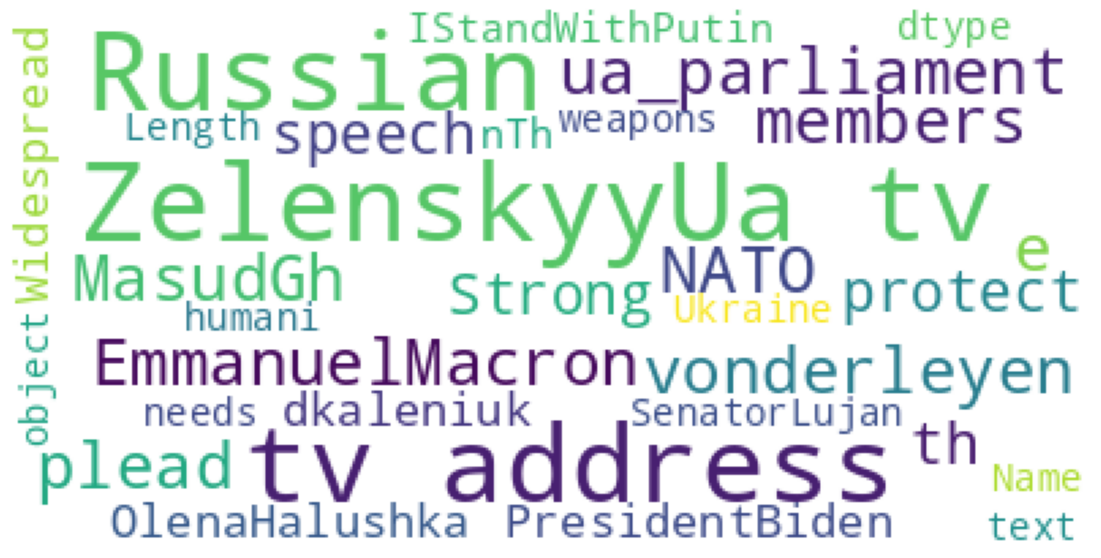

In [17]:
stopwords_set = set(STOPWORDS)
wordcloud = WordCloud(background_color='white',
                          stopwords=stopwords_set,
                          max_words=300,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(sorted_tweets['text']))

print(wordcloud)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
#fig.savefig("wordcloud_en.png", dpi=900)

In [18]:
unique_tweets = df_en.drop_duplicates(subset = ['text'])

# Lots of crypto, this is fairly interesting

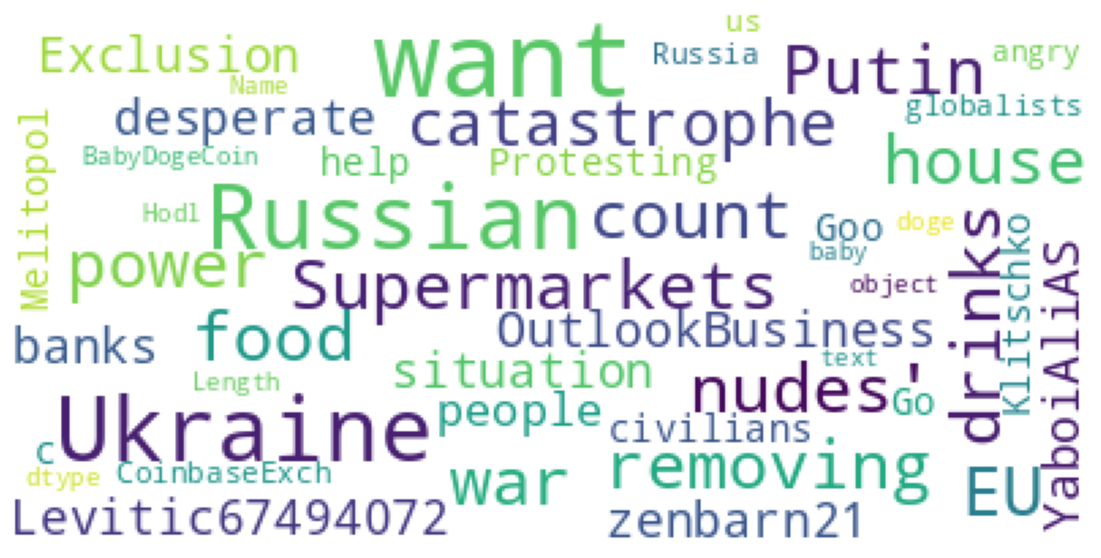

In [19]:
stopwords_set = set(stopwords.words('english')) #nltk
wordcloud = WordCloud(background_color='white',
                          stopwords=stopwords_set,
                          max_words=300,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(unique_tweets['text']))

print(wordcloud)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
#fig.savefig("wordcloud_en.png", dpi=900)

# Ukraine appears several times in different spelling/formatting i.e. kryllic, arabic, etc, must be the same for all others too
# looking at below, Ukraine is proabably 2nd 

<AxesSubplot:>

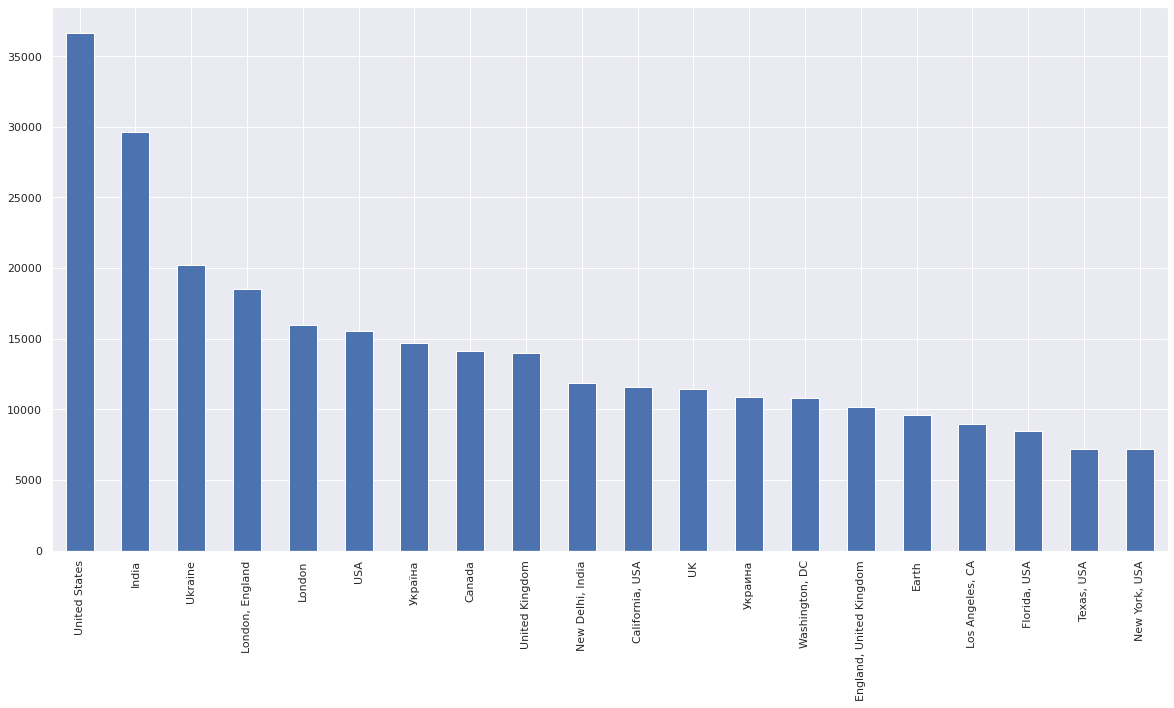

In [20]:
df_en.location.value_counts()[:20].plot.bar()

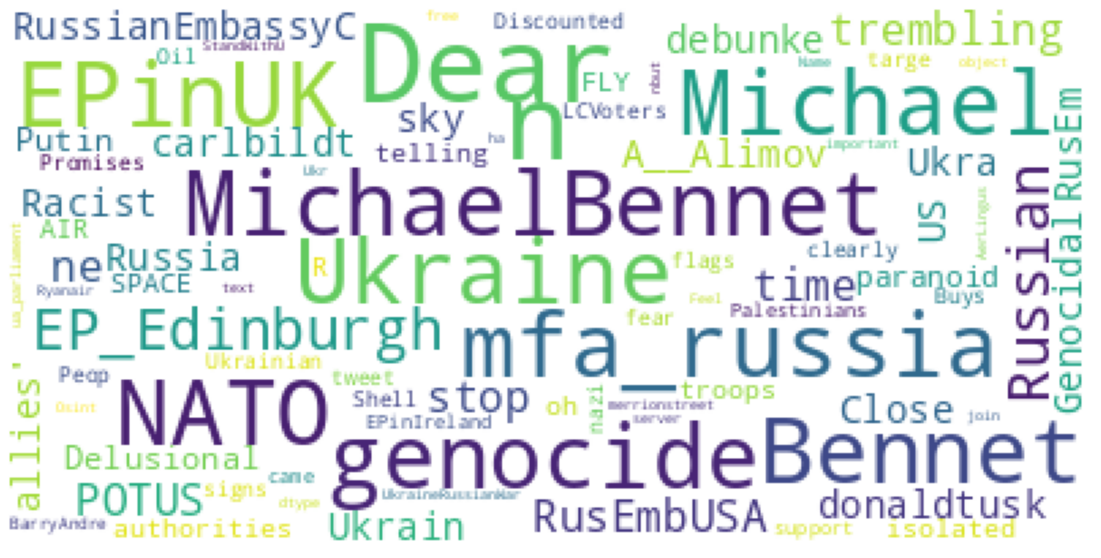

In [21]:
stopwords_set = set(stopwords.words('english')) #nltk
wordcloud = WordCloud(background_color='white',
                          stopwords=stopwords_set,
                          max_words=300,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(unique_tweets.sort_values(by = "retweetcount").iloc[:20]['text']))

print(wordcloud)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
#fig.savefig("wordcloud_en.png", dpi=900)

# Mike Bennett the senator? https://twitter.com/mikehypercube

In [22]:
time_cols = ['extractedts', 'tweetcreatedts', 'usercreatedts']

In [23]:
df_en[time_cols[2]] = pd.to_datetime(df_en[time_cols[2]])

In [24]:
sort_by_userage = df_en.sort_values(by = time_cols[2], ascending = True)

In [25]:
columns = df_en.columns.to_list()

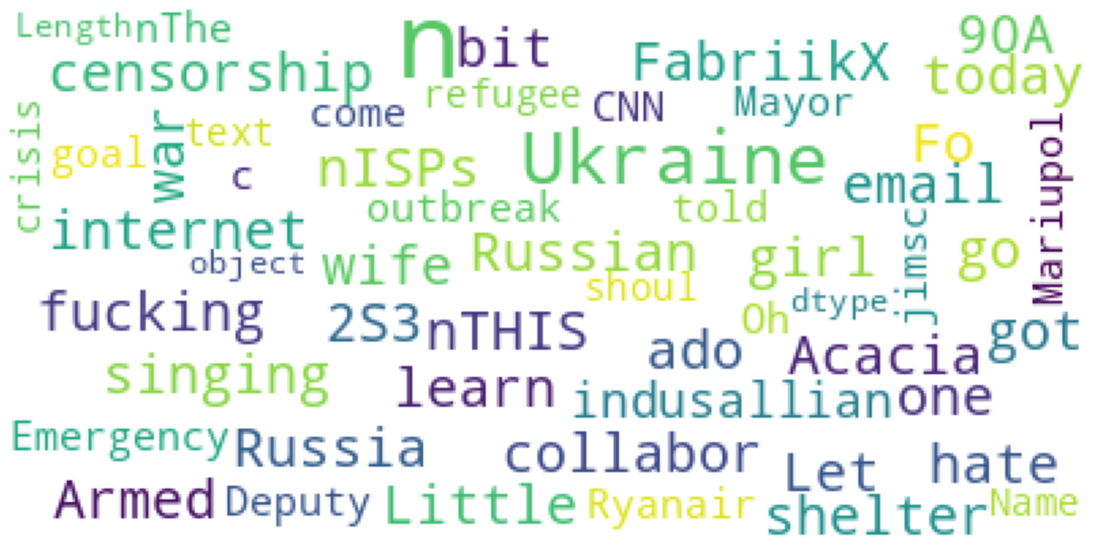

In [26]:
stopwords_set = set(stopwords.words('english')) #nltk
wordcloud = WordCloud(background_color='white',
                          stopwords=stopwords_set,
                          max_words=300,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(sort_by_userage.iloc[:1000, columns.index('text')]))

print(wordcloud)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
#fig.savefig("wordcloud_en.png", dpi=900)

/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128065 (\N{EYE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128221 (\N{MEMO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


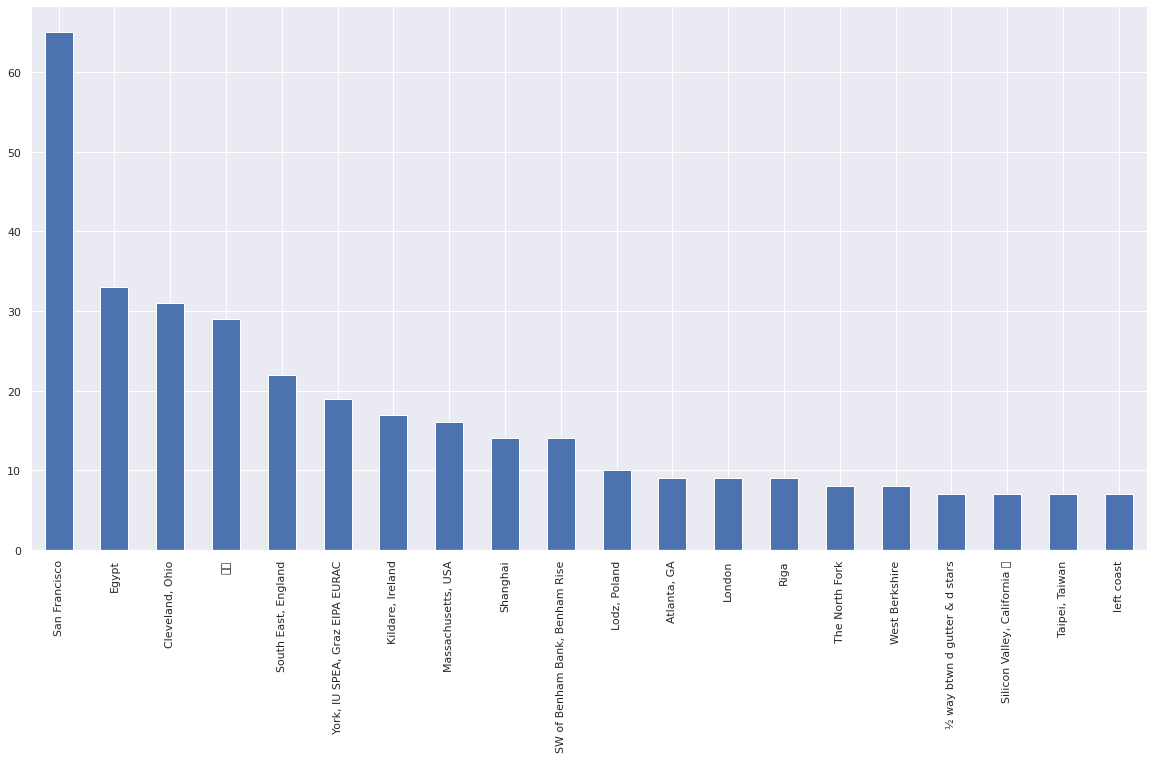

In [27]:
sort_by_userage.iloc[:1000, columns.index("location")].value_counts()[:20].plot.bar()
plt.show()

### hmm some weird font not showing guess special character

/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128065 (\N{EYE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128221 (\N{MEMO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


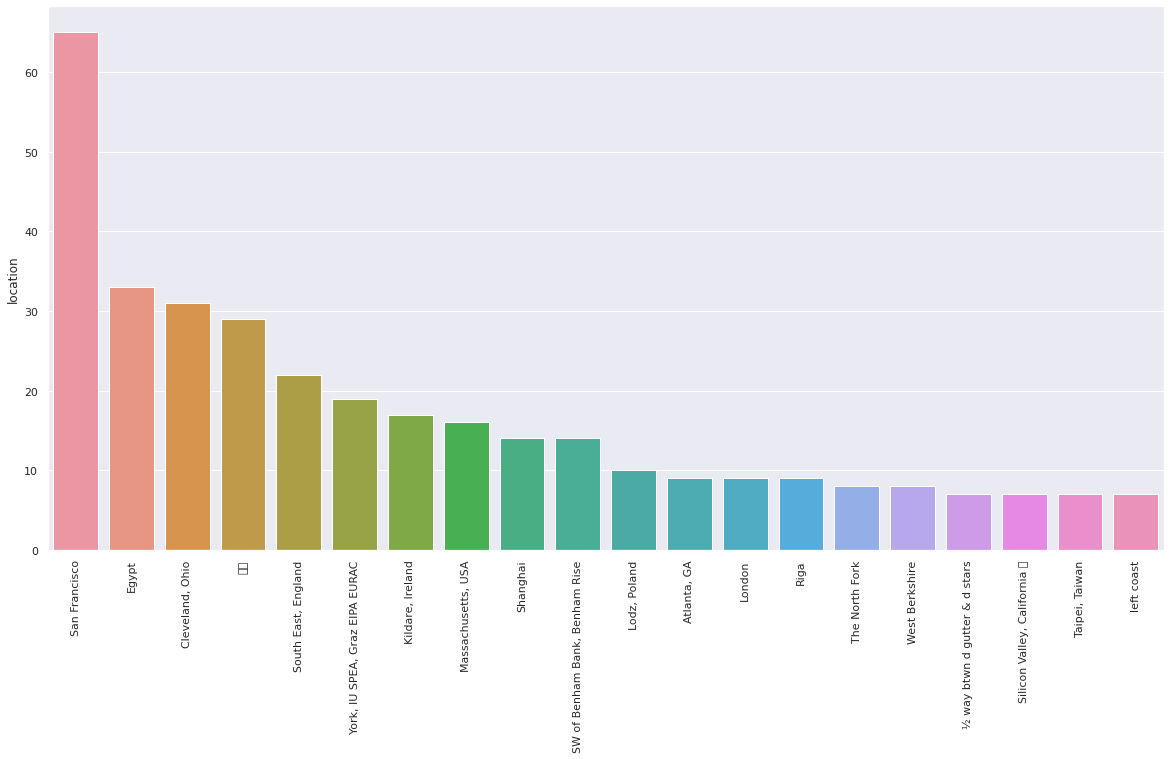

In [28]:
#oldest
sns.barplot(x = sort_by_userage.iloc[:1000, columns.index("location")].value_counts()[:20].index, y = sort_by_userage.iloc[:1000, columns.index("location")].value_counts()[:20])
plt.xticks(rotation = 90)
plt.show()

/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127752 (\N{RAINBOW}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


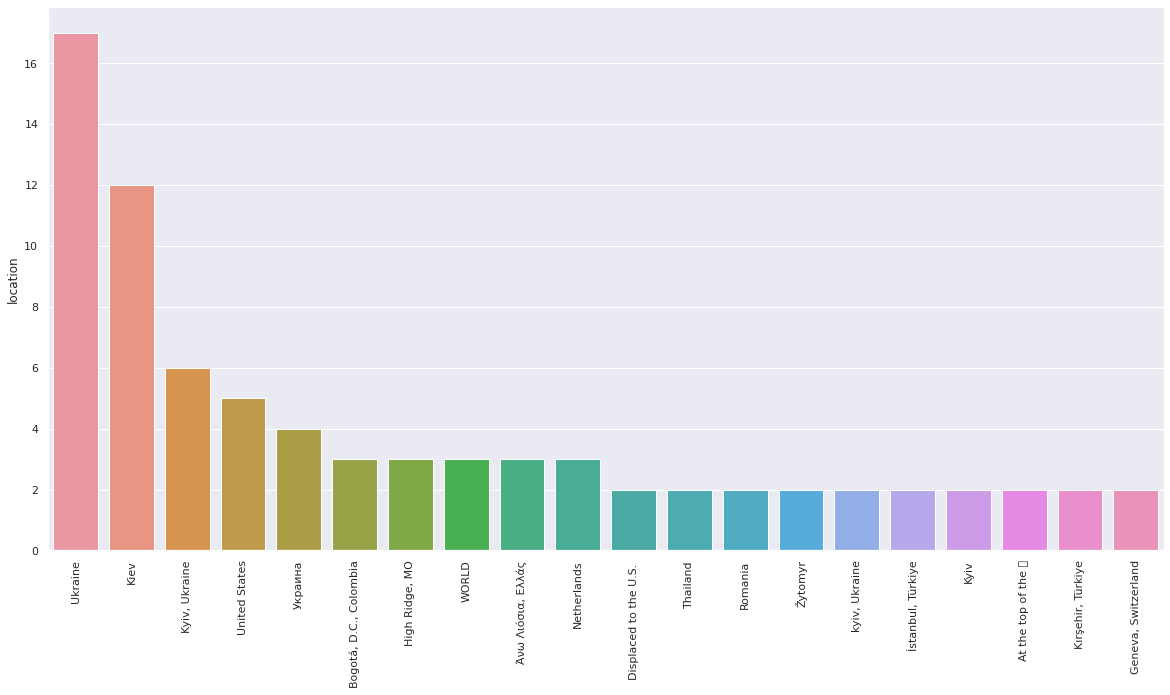

In [29]:
#newest, maybe specific bots
sns.barplot(x = sort_by_userage.iloc[df_en.shape[0] - 1000:,
                                     columns.index("location")].value_counts()[:20].index,
            y = sort_by_userage.iloc[df_en.shape[0] - 1000:, columns.index("location")].value_counts()[:20])
plt.xticks(rotation = 90)
plt.show()

In [30]:
num_chars = df_en.text.apply(len)
num_words = df_en.text.apply(lambda x: len(x.split()))
df_en['num_chars'] = num_chars
df_en['num_words'] = num_words

In [31]:
print(f"average num characters: {num_chars.mean()}")
print(f"average num words: {num_words.mean()}")
print(f"median num characters: {num_chars.median()}")
print(f"median num words: {num_words.median()}")

average num characters: 199.15559139981082
average num words: 27.778029700932095
median num characters: 198.0
median num words: 27.0


In [32]:
df_en.groupby('num_chars')['retweetcount', 'favorite_count'].describe()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


retweetcount                                            \
                 count mean       std  min   25%  50%   75%  max   
num_chars                                                          
5                  2.0  0.0  0.000000  0.0  0.00  0.0  0.00  0.0   
6                  2.0  0.0  0.000000  0.0  0.00  0.0  0.00  0.0   
10                 1.0  0.0       NaN  0.0  0.00  0.0  0.00  0.0   
11                28.0  0.0  0.000000  0.0  0.00  0.0  0.00  0.0   
12                16.0  0.0  0.000000  0.0  0.00  0.0  0.00  0.0   
...                ...  ...       ...  ...   ...  ...   ...  ...   
1005               2.0  1.5  0.707107  1.0  1.25  1.5  1.75  2.0   
1007               6.0  2.5  0.547723  2.0  2.00  2.5  3.00  3.0   
1018               1.0  0.0       NaN  0.0  0.00  0.0  0.00  0.0   
1031               1.0  2.0       NaN  2.0  2.00  2.0  2.00  2.0   
1033               4.0  3.0  2.581989  0.0  1.50  3.0  4.50  6.0   

          favorite_count                                               
                   count      mean       std  min  25%  50%  75%  max  
num_chars                                                              
5                    2.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  
6                    2.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  
10                   1.0  0.000000       NaN  0.0  0.0  0.0  0.0  0.0  
11                  28.0  0.071429  0.262265  0.0  0.0  0.0  0.0  1.0  
12                  16.0  0.250000  0.577350  0.0  0.0  0.0  0.0  2.0  
...                  ...       ...       ...  ...  ...  ...  ...  ...  
1005                 2.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  
1007                 6.0  1.833333  2.994439  0.0  0.0  0.0  3.0  7.0  
1018                 1.0  1.000000       NaN  1.0  1.0  1.0  1.0  1.0  
1031                 1.0  0.000000       NaN  0.0  0.0  0.0  0.0  0.0  
1033                 4.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  

[879 rows x 16 columns]